In [1]:
import os
import random
import matplotlib.pylab as plt
from glob import glob
import numpy as np

# READ IMAGES AND MASKS

In [2]:
PATH = os.path.abspath('data')

SOURCE_IMAGES = os.path.join(PATH, "images/resized")

images = glob(os.path.join(SOURCE_IMAGES, "*.jpg"))

SOURCE_LABELS = os.path.join(PATH, "labels/resized")

labels = glob(os.path.join(SOURCE_LABELS, "*.png"))

In [3]:
SOURCE_IMAGES

'/home/kenny/Desktop/copterutils/seg/data/images/resized'

In [4]:
images.sort()
labels.sort()

In [5]:
print(np.size(images))
print(np.size(labels))

80
80


In [6]:
x = [] # images
y = [] # labels

for img in images:
    full_size_image = plt.imread(img)
    x.append(full_size_image)

for lbl in labels:
    full_size_label = plt.imread(lbl,0)
    y.append(full_size_label)


In [7]:
x = np.asarray(x)
y = np.asarray(y)

In [8]:
y.max()

8

In [15]:
print(x.shape)
print(y.shape)

(80, 512, 640, 3)
(80, 512, 640, 9)


# Convert one mask to N masks

In [11]:
n_images, h, w = y.shape
y = y.reshape([n_images, h*w])
cs = ['background','asphalt', 'building', 'forest', 'grass', 'ground', 'roadAsphalt', 'roadGround', 'water']
n_classes = len(cs)
temp = np.zeros(np.append(y.shape,n_classes),dtype='bool_')

In [12]:
for i in range (n_images):
    for j in range(h*w):
            temp[i,j,(y[i,j])] = True
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


In [13]:
y = temp.reshape([n_images,h,w,n_classes])
y.shape
del(temp)

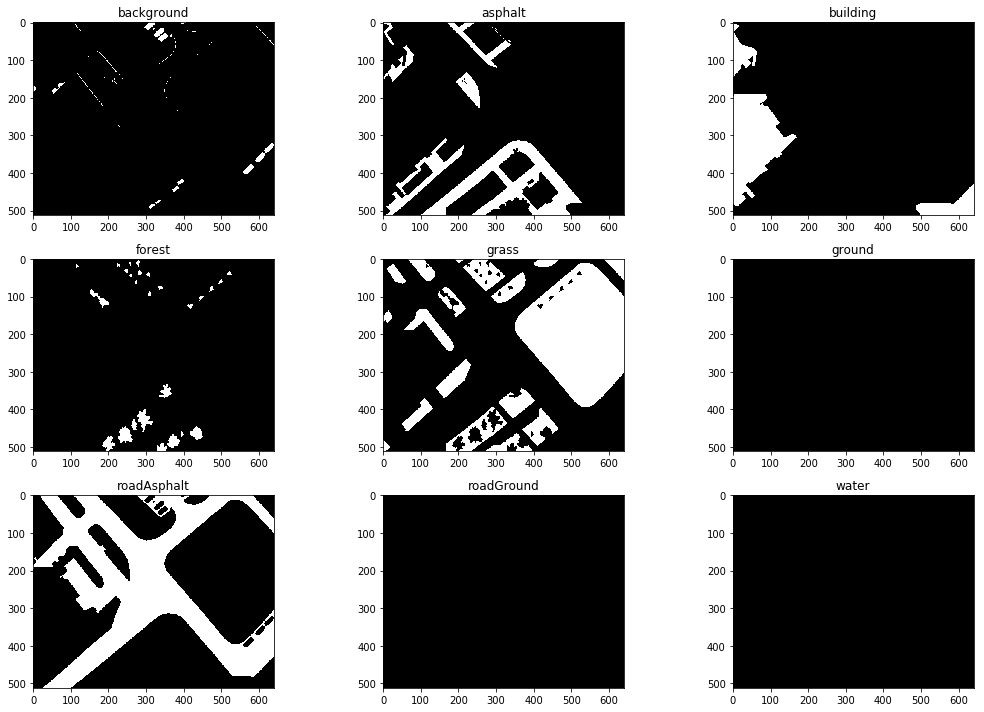

In [14]:
nrows, ncols = 3,3
fig, axes = plt.subplots(nrows=3, ncols=3)
fig.set_size_inches(15,10)
cl = 0
im = 59
for i in range(nrows):
    for j in range(ncols):
        axes[i,j].imshow(y[im,:,:,cl], cmap='gray')
        axes[i,j].set_title(cs[cl])
        cl += 1
        
fig.tight_layout()

In [16]:
print(x.shape)
print(y.shape)

(80, 512, 640, 3)
(80, 512, 640, 9)


# Prepare for training

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25, random_state=1)

In [20]:
print(x_train.shape)
print(y_train.shape)

(60, 512, 640, 3)
(60, 512, 640, 9)


In [21]:
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models, optimizers
from keras import backend as K

/home/kenny/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [22]:
import tensorflow as tf

In [23]:
K.image_data_format()

'channels_last'

In [26]:
img_width, img_height = w, h
nb_train_samples = len(x_train)
nb_test_samples = len(x_test)
epochs = 2
batch_size = 4

# Define model

In [34]:
import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.layers.merge import concatenate
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

def unet(pretrained_weights = None, input_size = (256,320,3), n_classes = 9):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
#     merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
#     merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
#     merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
#     merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(n_classes, 1, activation = 'softmax')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
#     model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [35]:
model = unet(input_size = (img_height,img_width,3))

In [29]:
train_datagen = ImageDataGenerator(rescale=1. / 255, horizontal_flip=True, rotation_range=30)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [31]:
train_generator = train_datagen.flow(np.array(x_train), y_train, batch_size=batch_size)
test_generator = test_datagen.flow(np.array(x_test), y_test, batch_size=batch_size)

# Training

In [ ]:
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
)

Epoch 1/2
 1/15 [=>............................] - ETA: 28:24 - loss: 2.3473 - acc: 0.0460